In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

In [3]:
data=pd.read_excel('/content/drive/MyDrive/NNFL data/Data_A2/data5.xlsx')

In [5]:
data.dropna(inplace=True)

In [7]:
data[data.columns[-1]].unique()

array([1., 2., 3.])

In [8]:
data=data.sample(frac=1)
data.head()

,15.260,14.840,0.871,5.763,3.312,2.221,5.220,1.000
131,15.38,14.90,0.8706,5.884,3.268,4.462,5.795,2.0
147,12.70,13.71,0.8491,5.386,2.911,3.260,5.316,3.0
44,13.80,14.04,0.8794,5.376,3.155,1.560,4.961,1.0
148,10.79,12.93,0.8107,5.317,2.648,5.462,5.194,3.0
26,12.74,13.67,0.8564,5.395,2.956,2.504,4.869,1.0


In [9]:
class_one = data[data.iloc[:,-1]==1][0:210]
class_two = data[data.iloc[:,-1]==2][0:210]
class_three = data[data.iloc[:,-1]==3][0:210]

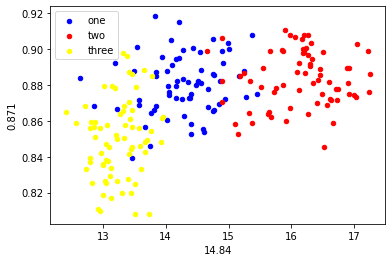

In [10]:
axes = class_one.plot(kind='scatter', x=1, y=2, color='blue', label='one')
class_two.plot(kind='scatter', x=1, y=2, color='red', label='two', ax=axes)
class_three.plot(kind='scatter', x=1, y=2, color='yellow', label='three', ax=axes)


In [11]:
def clustering(k):
    kmeans=KMeans(n_clusters=k).fit(train_x)
    return kmeans

In [12]:
def kernel(x,mu,sigma,kernel_funct):
    beta=1/(2*sigma*sigma)
    if kernel_funct == "gaussian":
        return np.exp(-beta*(np.linalg.norm(x-mu))**2)
    elif kernel_funct == "multi-quadric":
        return ((np.linalg.norm(x-mu))**2+sigma**2)**0.5
    elif kernel_funct == "linear":
        return np.linalg.norm(x-mu)

In [13]:
def compute_sigma(x,labels,mu):
    c=mu.shape[0]
    sigma=np.zeros(c)
    for i in range(c):
        x_temp=x[labels==i]
        k=0
        for j in range(x_temp.shape[0]):
            k+=np.linalg.norm(x_temp[j]-mu[i])
        sigma[i]=k/x_temp.shape[0]
    return sigma

In [14]:
def compute_H(X,mu,sigma,kernel_funct):
    c=mu.shape[0]
    H=np.zeros((X.shape[0],c))
    for i in range(H.shape[0]):
        for j in range(H.shape[1]):
            H[i][j]=kernel(X[i],mu[j],sigma[j],kernel_funct)
    return H

In [15]:
X=data.iloc[:,:-1].values
Y=data.iloc[:,-1].values
xmin=np.min(X,axis=0)
xmax=np.max(X,axis=0)
X=(X-xmin)/(xmax-xmin)#performing normalization on input features  
# m=X.shape[0]
# pp=np.ones([m,1])
# X=np.append(pp,X,axis=1)
train_x,test_x,train_y,test_y=train_test_split(X,Y,test_size=0.2,train_size=0.8,shuffle=True)
train_x,valid_x,train_y,valid_y=train_test_split(train_x,train_y,test_size=0.125,train_size=0.875,shuffle=True)
train_y=np.reshape(train_y,newshape=(train_y.shape[0],1))
valid_y=np.reshape(valid_y,newshape=(valid_y.shape[0],1))
test_y=np.reshape(test_y,newshape=(test_y.shape[0],1))


In [16]:
def compute(kernel_funct,xtrain,ytrain,xtest,ytest):
    kmeans=clustering(15)
    mu=kmeans.cluster_centers_
    sigma=compute_sigma(xtrain,kmeans.labels_,mu)
    H=compute_H(xtrain,mu,sigma,kernel_funct)
    W=np.dot(np.linalg.pinv(H),ytrain)
    H=compute_H(xtest,mu,sigma,kernel_funct)
    pred=np.dot(H,W)
    p=(pred>0.5).astype(int)
    a=(p!=ytest).astype(int)
    
    return (ytest.shape[0]-np.sum(a))/ytest.shape[0]

In [17]:
muquad_acc = compute("multi-quadric",train_x,train_y,test_x,test_y)
lin_acc = compute("linear",train_x,train_y,test_x,test_y)
gaussian_acc=compute("gaussian",train_x,train_y,test_x,test_y)

In [18]:
print("Accuracy for Multi quadric kernel is: {0}%".format(round(muquad_acc*100,2)))
print("Accuracy for Linear kernel is: {0}%".format(round(lin_acc*100,2)))
print("Accuracy for Gaussian kernel is: {0}%".format(round(gaussian_acc*100,2)))

Accuracy for Multi quadric kernel is: 40.48%
Accuracy for Linear kernel is: 40.48%
Accuracy for Gaussian kernel is: 38.1%


In [19]:
kf = KFold(n_splits=5)
X=data.iloc[:,:-1].values
X=(X-np.mean(X,axis=0))/(np.std(X,axis=0))
Y=data.iloc[:,-1].values
Y=np.reshape(Y,newshape=(-1,1))
kf.get_n_splits(X)
fold = 0
accuracy = 0
overall_mq = 0
overall_lin = 0
overall_gauss=0
for train_index, test_index in kf.split(X):
    fold+=1
    X_train=X[train_index]
    Y_train=Y[train_index]
    X_test=X[test_index]
    Y_test=Y[test_index]
    mquad_acc_val = compute("multi-quadric",train_x,train_y,test_x,test_y)
    lin_acc_val = compute("linear",train_x,train_y,test_x,test_y)
    gaussian_acc_val=compute("gaussian",train_x,train_y,test_x,test_y)
    overall_mq+=mquad_acc_val
    overall_lin+=lin_acc_val
    overall_gauss+=gaussian_acc_val
    print("Fold: {0}, Accuracy for multi quadratic kernel: {1}%".format(fold,round(mquad_acc_val*100,2)))
    print("Fold: {0}, Accuracy for linear kernel: {1}%".format(fold,round(lin_acc_val*100,2)))
    print("Fold: {0}, Accuracy for gaussian kernel: {1}%".format(fold,round(gaussian_acc_val*100,2)))
print("overall accuracy is for Multiquad is: {0}%".format(round(overall_mq/5*100,2)))
print("overall accuracy is for linear  is: {0}%".format(round(overall_lin/5*100,2)))
print("overall accuracy is for Gaussian  is: {0}%".format(round(overall_gauss/5*100,2)))

Fold: 1, Accuracy for multi quadratic kernel: 40.48%
Fold: 1, Accuracy for linear kernel: 40.48%
Fold: 1, Accuracy for gaussian kernel: 38.1%
Fold: 2, Accuracy for multi quadratic kernel: 40.48%
Fold: 2, Accuracy for linear kernel: 40.48%
Fold: 2, Accuracy for gaussian kernel: 35.71%
Fold: 3, Accuracy for multi quadratic kernel: 40.48%
Fold: 3, Accuracy for linear kernel: 40.48%
Fold: 3, Accuracy for gaussian kernel: 35.71%
Fold: 4, Accuracy for multi quadratic kernel: 40.48%
Fold: 4, Accuracy for linear kernel: 40.48%
Fold: 4, Accuracy for gaussian kernel: 38.1%
Fold: 5, Accuracy for multi quadratic kernel: 40.48%
Fold: 5, Accuracy for linear kernel: 40.48%
Fold: 5, Accuracy for gaussian kernel: 33.33%
overall accuracy is for Multiquad is: 40.48%
overall accuracy is for linear  is: 40.48%
overall accuracy is for Gaussian  is: 36.19%
